# I - Modèle de Time Serie :  SARIMAX sur la production

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans
from matplotlib import rcParams

import feather

from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse, meanabs


# Charge le fichier feather
df = pd.read_feather('data/energy_clean.ftr')
df = df.set_index('date_heure')

sns.set_theme(context='talk', style='darkgrid')

import warnings
warnings.filterwarnings("ignore")

## I.1 - Création des jeux de données
On utilise `pd.Grouper` pour grouper par Mois avec `freq='M'`.

Avec `mean`, les résulats ne sont pas très lisisbles, il est préférable d'utiliser `sum`.


In [2]:
# Colonnes à garder dans le jeu de données
cols = ['consommation', 'total_prod']
df = df[cols]
# Renomme les noms pour être plus faciles à utiliser
df.rename(columns={'consommation': 'conso', 'total_prod': 'prod'}, inplace=True)

# Groupby par Jours avec la moyenne de production et la somme
data = df.groupby(pd.Grouper(freq='M'))[['conso', 'prod']].sum()

# Conversion en Terawatt
data['conso'] = data['conso'].apply(lambda x: round(x/1000000, 5))
data['prod'] = data['prod'].apply(lambda x: round(x/1000000, 5))
# Fromatte les index sous la forme AAAA-MM
data.index = data.index.strftime('%Y-%m')
data.index = pd.to_datetime(data.index)

# Sauvegarde le travail
data_to_save = data.copy()
data_to_save = data_to_save.reset_index()
data_to_save.to_feather('data/timeserie.ftr')

## I.2 - Seasonal Decompose

Permet de visualiser la saisonnalité, si elle existe.
Le modèle *multiplicative* correspond mieux.

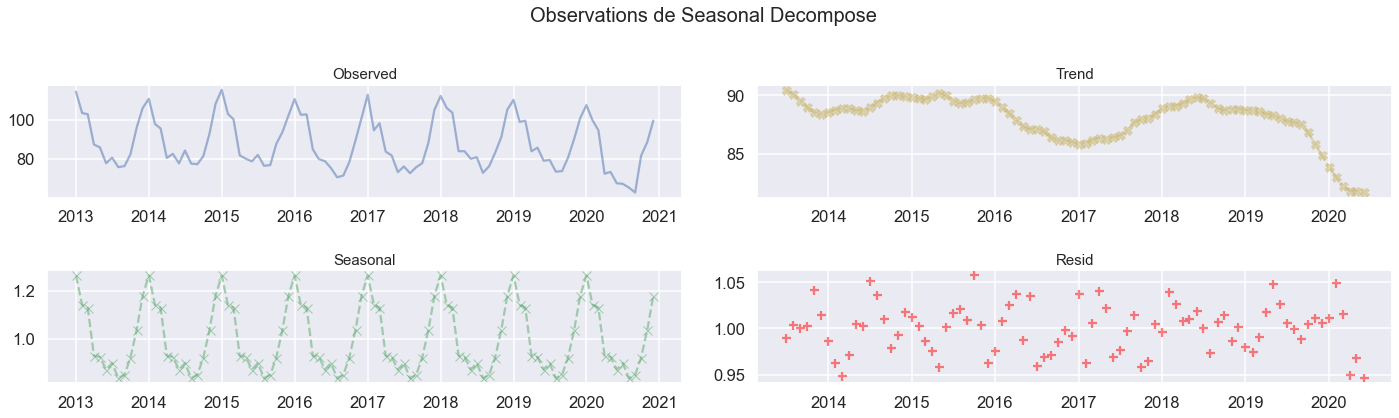

In [3]:
decompose = seasonal_decompose(data['prod'], model='multiplicative')


fig, ax = plt.subplots(2, 2, figsize=(20, 6))
fig.tight_layout(h_pad=3)

trans = mtrans.Affine2D().translate(35, 0)

fig.suptitle('Observations de Seasonal Decompose', fontsize=20)
fig.subplots_adjust(top=.8)

ax[0, 0].plot(decompose.observed, alpha=.5)
ax[0, 0].set_title('Observed', fontsize=15)


ax[0, 1].plot(decompose.trend, 'y-.X', alpha=.5)
ax[0, 1].set_title('Trend', fontsize=15)


ax[1, 0].plot(decompose.seasonal, 'g--x', alpha=.5)
ax[1, 0].set_title('Seasonal', fontsize=15)


ax[1, 1].scatter(decompose.resid.index, decompose.resid.values, marker='+', c='red', alpha=.5)
ax[1, 1].set_title('Resid', fontsize=15)


plt.savefig("Outputs/5.1_-_SARIMAX_prod_seasonal_decompose.png", dpi=150, bbox_inches='tight')
plt.show()

### Interprétation de Seasonal Decompose

On constate assez facilement une saisonnalité d'année avec une tendance à la baisse pour l'année 2020.

## I.3 - Auto ARIMA
La fonction `auto_arima` du parquet `pmdarima` permet de trouver les meilleurs paramètres pour le modèle SARIMAX:

* Sur la variable `prod`
* `m` indique la fréquence, ici 12
* `trace=True` permet d'afficher les infos (supprimé par la suite)
* `.summary()` affiche les résultats et les meilleurs paramètres à utuliser

In [4]:
auto_arima(data['prod'], m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   96
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 12)   Log Likelihood                -216.775
Date:                            Thu, 29 Jul 2021   AIC                            443.550
Time:                                    14:55:19   BIC                            455.704
Sample:                                         0   HQIC                           448.436
                                             - 96                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.6920      0.460     -1.505      0.132      -1.593       0.209
ar.L1          0.5991      0.081      7.396      0.000       0.440       0.758
ar.S.L12      -0.6003      0.119     -5.032      0.000      -0.834      -0.367
ar.S.L24      -0.3150      0.124     -2.549      0.011      -0.557      -0.073
sigma2         9.5346      1.493      6.384      0.000       6.608      12.462
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                 0.60
Prob(Q):                              0.66   Prob(JB):                         0.74
Heteroskedasticity (H):               1.94   Skew:                             0.05
Prob(H) (two-sided):                  0.09   Kurtosis:                         3.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Interprétations de `auto_arima`

L'élément `Modele` indique les meilleurs paramètres à utiliser pour le modèle SARIMAX.
On distingue des p-values (P<|z|) en dessous, ce qui laisse penser que les prédictions seront relativement correctes.

## I.4 - Modélisation SARIMAX

Implémentation du modèle SARIMAX:
* Division du jeu de données (test size = 25%)
* Initialisation de SARIMAX
    * `prod`
    * `order=(1, 0, 0)`
    * `seasonal_order=(2, 1, 0, 12)`
* Entrainement
* Définition du début et de la fin de la prédiction


In [5]:
#SARIMAX(1, 0, 0)x(1, 0, 1, 12)
# data.shape[0] == 96
# Divisé en 4 -> 72:24

train = data.iloc[:72]
test = data.iloc[72:]

mod = SARIMAX(train['prod'], order=(1, 0, 0), seasonal_order=(2, 1, 0, 12))
res = mod.fit()

start = len(train)
end = len(train) + len(test) - 1

prediction = res.predict(start, end).rename('Prediction')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.13656D+00    |proj g|=  1.09965D-01

At iterate    5    f=  2.06463D+00    |proj g|=  2.32235D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     10      1     0     0   1.602D-06   2.065D+00
  F =   2.0646235964822410     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


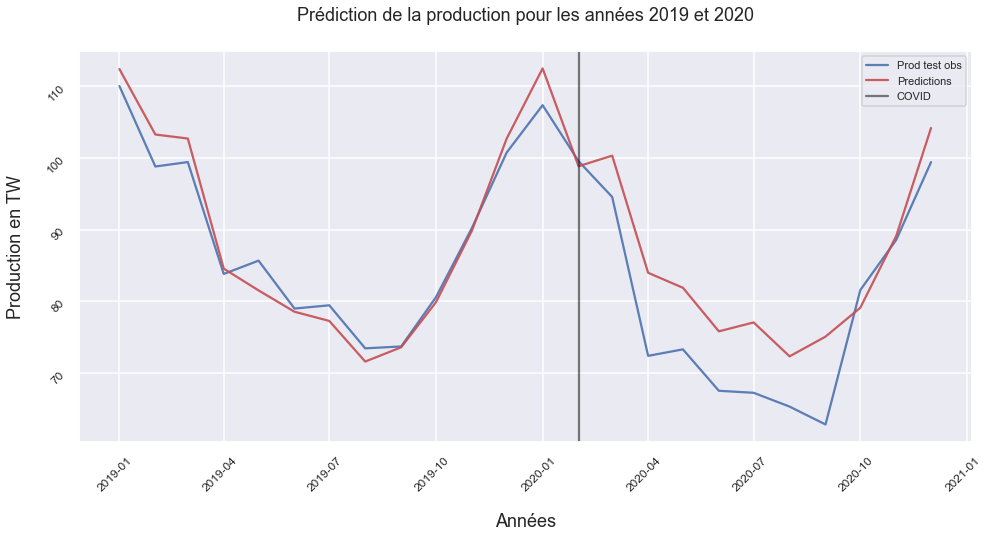

In [6]:
fig, ax = plt.subplots(figsize = (16,8))

plt.plot(test.index, test['prod'], color='b', alpha=.9, label='Prod test obs')

ax = prediction.plot(legend=True, color='r', alpha=.9, label='Predictions')

plt.xlabel('Années', labelpad=20)
# Permet de centrer l'année sur la colonne
trans = mtrans.Affine2D().translate(15, 0)
for t in ax.get_xticklabels():
    t.set_transform(t.get_transform()+trans)

plt.xticks(fontsize=12, rotation=45)


plt.ylabel('Production en TW', labelpad=20)
plt.yticks(fontsize=12, rotation=45)

plt.axvline(x=test.index[13], color='black', alpha=.5, label='COVID'); # Ajout de la ligne verticale

plt.title('Prédiction de la production pour les années 2019 et 2020', pad=30)
plt.legend(fontsize=11, loc='best')

plt.savefig("Outputs/5.1_-_SARIMAX_prod.png", dpi=150, bbox_inches='tight')

plt.show()

In [7]:
print('RMSE:', round(rmse(test['prod'], prediction), 4))
print('MAE:', round(meanabs(test['prod'], prediction), 4), '%')

RMSE: 5.5089
MAE: 4.1469 %


## I.5 - Interprétations SARIMAX
### 1. Graphique de prédiction
On constate d'assez bonnes prédictions bien qu'elles soient surestimées pour l'années 2020.
En effet, la prédiction semble suivre une tendence régulière alors que les observations pour 2020 sont bien en dessous de ce que l'on pourrait s'attendre.

### 2. Metriques
Pour interpréter ces résultats, j'ai utilisé deux métriques:
* L'erreur quatratique moyenne (RMSE): moyenne des carrés des différences entre prédictions et observations.
* L'erreur absolue moyenne (MAE): moyenne arithmétique des valeurs absolues des écarts.

RMSE devrait être un peu plus faible si l'année 2020 n'était pas aussi atypique que les observations nous le laissent imaginer. Malgré tout, cela semble satisfaisant.

Couplé au MAE, qui nous indique 4% d'erreur, on pourrait largement se satisfaire du modèle tel qu'il est.

## Evolutions possibles

Il est probablement possible d'améliorer le modèle en y intégrant la variable de consommation.
En effet, on constate que les variables de production et de consommation sont étroitement corrélées. Cela semble évidement puisque les prédictions de production ont pour but d'éviter les risques de 'blackout'.

# Conclusion

Il est à noter que 2020 est une année atypique: la COVID semble avoir eu un impact assez fort sur la production et donc très probablement sur la consommation.
Les deux graphique suivant indique effectivement une baisse de la consommation énergétique en 2020 ainsi qu'une étroite corrélation entre production et consommation.

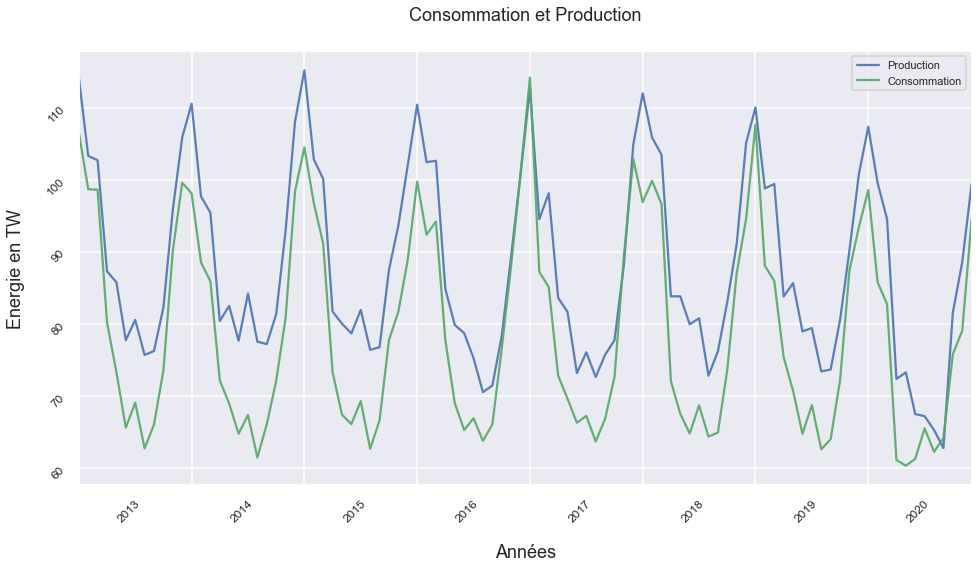

In [8]:
fig, ax = plt.subplots(figsize = (16,8))

ax = data['prod'].plot(legend=True, color='b', alpha=.9, label='Production')
ax = data['conso'].plot(legend=True, color='g', alpha=.9, label='Consommation')

plt.xlabel('Années', labelpad=20)
# Permet de centrer l'année sur la colonne
trans = mtrans.Affine2D().translate(50, 0)
for t in ax.get_xticklabels():
    t.set_transform(t.get_transform()+trans)

plt.xticks(fontsize=12, rotation=45)

plt.ylabel('Energie en TW', labelpad=20)
plt.yticks(fontsize=12, rotation=45)

plt.title('Consommation et Production', pad=30)
plt.legend(fontsize=11, loc='best')

plt.show()

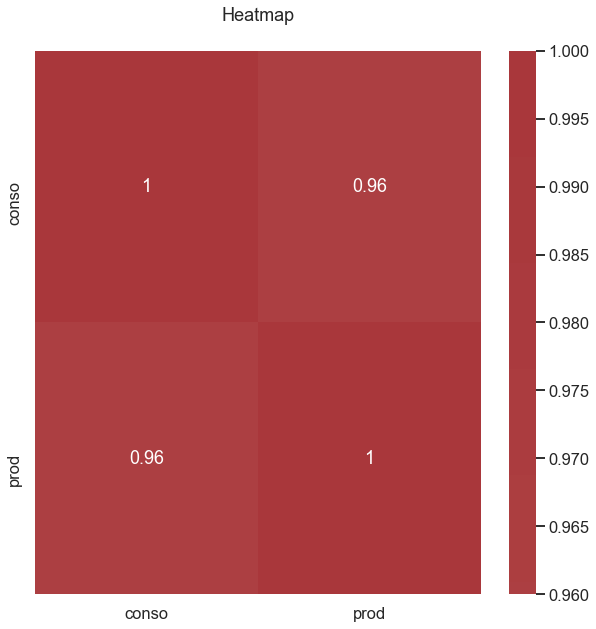

In [9]:
plt.figure(figsize=(10, 10))
sns.heatmap(data.corr().apply(lambda x: abs(round(x, 2))), center=0, annot=True, cmap='vlag')
plt.title('Heatmap', pad=30)
plt.show()

In [10]:
preds = pd.DataFrame(prediction).reset_index()
preds.rename(columns={'index': 'date_heure', 'Prediction': 'pred_prod'}, inplace=True)
updated = data.reset_index()
updated = pd.merge(left=updated, right=preds, on='date_heure', how='left')

updated.to_feather('data/timeserie_preds_prods.ftr')

In [11]:
df = updated.copy()
data = df.set_index('date_heure')

# II - Modèle de Time Serie :  SARIMAX sur la consommation
## II.1 - Seasonal Decompose

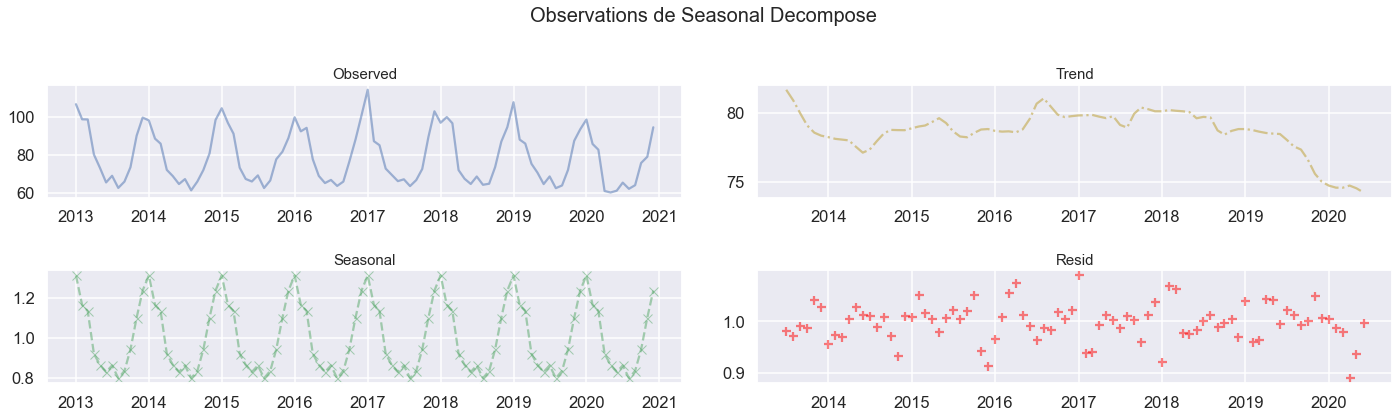

In [12]:
decompose = seasonal_decompose(data['conso'], model='multiplicative')


fig, ax = plt.subplots(2, 2, figsize=(20, 6))
fig.tight_layout(h_pad=3)

trans = mtrans.Affine2D().translate(35, 0)

fig.suptitle('Observations de Seasonal Decompose', fontsize=20)
fig.subplots_adjust(top=.8)

ax[0, 0].plot(decompose.observed, alpha=.5)
ax[0, 0].set_title('Observed', fontsize=15)


ax[0, 1].plot(decompose.trend, 'y-.', alpha=.8)
ax[0, 1].set_title('Trend', fontsize=15)


ax[1, 0].plot(decompose.seasonal, 'g--x', alpha=.5)
ax[1, 0].set_title('Seasonal', fontsize=15)


ax[1, 1].scatter(decompose.resid.index, decompose.resid.values, marker='+', c='red', alpha=.5)
ax[1, 1].set_title('Resid', fontsize=15)

plt.savefig("Outputs/5.1_-_SARIMAX_conso_seasonal.png", dpi=150, bbox_inches='tight')


plt.show()

### Interprétation de Seasonal Decompose

On constate assez facilement une saisonnalité d'année avec une tendance à la baisse pour l'année 2020.

## II.2 - Auto ARIMA
La fonction `auto_arima` du parquet `pmdarima` permet de trouver les meilleurs paramètres pour le modèle SARIMAX:

* Sur la variable `prod`
* `m` indique la fréquence, ici 12
* `trace=True` permet d'afficher les infos
* `.summary()` affiche les résultats et les meilleurs paramètres à utuliser

In [13]:
auto_arima(data['conso'], m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                   96
Model:             SARIMAX(1, 0, 0)x(1, 0, [1, 2], 12)   Log Likelihood                -283.702
Date:                                 Thu, 29 Jul 2021   AIC                            579.404
Time:                                         14:55:28   BIC                            594.790
Sample:                                              0   HQIC                           585.623
                                                  - 96                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.7734      1.197      1.482      0.138      -0.572       4.119
ar.L1          0.4765      0.078      6.135      0.000       0.324       0.629
ar.S.L12       0.9557      0.031     31.104      0.000       0.895       1.016
ma.S.L12      -1.0685      0.149     -7.156      0.000      -1.361      -0.776
ma.S.L24       0.5887      0.188      3.138      0.002       0.221       0.956
sigma2        15.1313      2.361      6.409      0.000      10.504      19.759
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                21.28
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             0.58
Prob(H) (two-sided):                  0.30   Kurtosis:                         4.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Interprétations de `auto_arima`

L'élément `Modele` indique les meilleurs paramètres à utiliser pour le modèle SARIMAX.
On distingue des p-values (P<|z|) en dessous, ce qui laisse penser que les prédictions seront relativement correctes.

## II.3 - Modélisation SARIMAX

Implémentation du modèle SARIMAX:
* Division du jeu de données (test size = 25%)
* Initialisation de SARIMAX
    * `prod`
    * `order=(1, 0, 0)`
    * `seasonal_order=(1, 0, [1, 2], 12)`
* Entrainement
* Définition du début et de la fin de la prédiction


In [14]:
# SARIMAX(1, 0, 0)x(1, 0, [1, 2], 12)
# data.shape[0] == 96
# Divisé en 4 -> 72:24

train = data.iloc[:72]
test = data.iloc[72:]

mod = SARIMAX(train['conso'], order=(1, 0, 0), seasonal_order=(1, 0, [1, 2], 12))
res = mod.fit()

start = len(train)
end = len(train) + len(test) - 1

prediction = res.predict(start, end).rename('Prediction')


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.68144D+00    |proj g|=  6.31493D-01

At iterate    5    f=  3.46902D+00    |proj g|=  6.47679D-02

At iterate   10    f=  3.20835D+00    |proj g|=  4.84311D-02

At iterate   15    f=  3.15757D+00    |proj g|=  4.93925D-02

At iterate   20    f=  3.12829D+00    |proj g|=  6.51061D-03

At iterate   25    f=  3.11881D+00    |proj g|=  7.50596D-03

At iterate   30    f=  3.11679D+00    |proj g|=  7.28568D-04

At iterate   35    f=  3.11677D+00    |proj g|=  1.02637D-03

At iterate   40    f=  3.11675D+00    |proj g|=  3.48282D-04

At iterate   45    f=  3.11675D+00    |proj g|=  2.60541D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

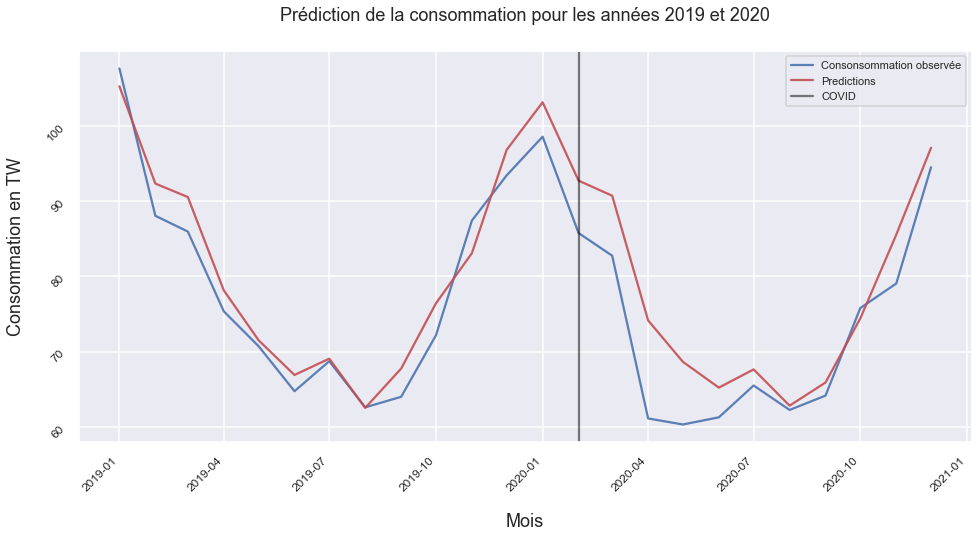

In [15]:
fig, ax = plt.subplots(figsize = (16,8))

plt.plot(test.index, test['conso'], color='b', alpha=.9, label='Consonsommation observée')

ax = prediction.plot(legend=True, color='r', alpha=.9, label='Predictions')

plt.xlabel('Mois', labelpad=20)

plt.xticks(fontsize=12, rotation=45)

plt.ylabel('Consommation en TW', labelpad=20)
plt.yticks(fontsize=12, rotation=45)

plt.axvline(x=test.index[13], color='black', alpha=.5, label='COVID'); # Ajout de la ligne verticale

plt.title('Prédiction de la consommation pour les années 2019 et 2020', pad=30)
plt.legend(fontsize=11, loc='best')
plt.savefig("Outputs/5.2_-_SARIMAX_conso.png", dpi=150, bbox_inches='tight')


plt.show()

In [16]:
print('RMSE:', round(rmse(test['conso'], prediction), 4))
print('MAE:', round(meanabs(test['conso'], prediction), 4), '%')

RMSE: 4.854
MAE: 3.863 %


## II.4 Interprétations SARIMAX
### 1. Graphique de prédiction
On constate d'assez bonnes prédictions bien qu'elles soient surestimées au printemps 2020, comme on pouvait s'y attendre.

### 2. Metriques
Pour interpréter ces résultats, j'ai utilisé deux métriques:
* L'erreur quatratique moyenne (RMSE): moyenne des carrés des différences entre prédictions et observations.
* L'erreur absolue moyenne (MAE): moyenne arithmétique des valeurs absolues des écarts.

Comme pour la production, les métriques sont satisfaisantes bien que l'année 2020, étant atypique, les fasse baisser.

# Conclusion
Je vais sauvegarder les prédictions afin de pouvoir les utiliser dans la prochaine partie dans le but de tester un modèle avec les variables de consommation et de production.

In [17]:
preds = pd.DataFrame(prediction).reset_index()
preds.rename(columns={'index': 'date_heure', 'Prediction': 'pred_conso'}, inplace=True)
updated = data.reset_index()
updated = pd.merge(left=updated, right=preds, on='date_heure', how='left')
updated.to_feather('data/timeserie_preds.ftr')

# III - Test d'un modele de Time Serie :  SARIMAX sur Production et Consommation
## III.1 - Auto ARIMA
La fonction `auto_arima` du parquet `pmdarima` permet de trouver les meilleurs paramètres pour le modèle SARIMAX:

* Sur la variable `y=prod` et `X=conso`
* `m` indique la fréquence, ici 12
* `trace=True` permet d'afficher les infos
* `.summary()` affiche les résultats et les meilleurs paramètres à utuliser

In [18]:
data = updated.set_index('date_heure')

train = data.iloc[:72]
test = data.iloc[72:]

auto_arima(y=train['prod'], X=train[['conso']], m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   72
Model:             SARIMAX(1, 0, 2)x(1, 0, 2, 12)   Log Likelihood                -168.866
Date:                            Thu, 29 Jul 2021   AIC                            355.731
Time:                                    14:55:44   BIC                            376.221
Sample:                                01-01-2013   HQIC                           363.888
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.9519      3.212      0.296      0.767      -5.343       7.247
conso          0.4616      0.061      7.603      0.000       0.343       0.581
ar.L1          0.0145      0.294      0.049      0.961      -0.561       0.590
ma.L1          0.7568      0.267      2.839      0.005       0.234       1.279
ma.L2          0.4315      0.168      2.569      0.010       0.102       0.761
ar.S.L12       0.9816      0.060     16.491      0.000       0.865       1.098
ma.S.L12      -0.4305      0.275     -1.564      0.118      -0.970       0.109
ma.S.L24      -0.2355      0.276     -0.854      0.393      -0.776       0.305
sigma2         4.7230      1.628      2.902      0.004       1.533       7.913
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 0.69
Prob(Q):                              0.83   Prob(JB):                         0.71
Heteroskedasticity (H):               1.95   Skew:                            -0.17
Prob(H) (two-sided):                  0.11   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Interprétations de `auto_arima`

L'élément `Modele` indique les meilleurs paramètres à utiliser pour le modèle SARIMAX.
On distingue des p-values (P<|z|) en dessous de 5% mais quelques-unes très élevées, ce qui laisse penser que les prédictions seront moyennes.

## III.2 - Modélisation SARIMAX sur la Production avec exog. Consommation

Implémentation du modèle SARIMAX:
* Division du jeu de données (test size = 25%)
* Initialisation de SARIMAX
    * `prod`
    * `order=(1, 0, 2)`
    * `seasonal_order=(1, 0, 2, 12)`
    * ***`exog`*** variable à ajouter dans le modèle
* Entrainement
* Définition du début et de la fin de la prédiction


In [19]:
# SARIMAX(1, 0, 2)x(1, 0, 2, 12)

mod = SARIMAX(train['prod'], exog=train['conso'], order=(1, 0, 2), seasonal_order=(1, 0, 2, 12))
res = mod.fit()

start = len(train)
end = len(train) + len(test) - 1

prediction = res.predict(start, end, exog=test[['pred_conso']]).rename('Prediction')


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75835D+00    |proj g|=  1.35270D+00

At iterate    5    f=  2.70924D+00    |proj g|=  3.28138D-01

At iterate   10    f=  2.69889D+00    |proj g|=  9.23547D-02

At iterate   15    f=  2.66052D+00    |proj g|=  3.33231D-01

At iterate   20    f=  2.50644D+00    |proj g|=  1.66505D-01


 This problem is unconstrained.



At iterate   25    f=  2.46736D+00    |proj g|=  3.87472D-02

At iterate   30    f=  2.45683D+00    |proj g|=  1.04594D-02

At iterate   35    f=  2.43895D+00    |proj g|=  3.27227D-02

At iterate   40    f=  2.43203D+00    |proj g|=  7.36648D-03

At iterate   45    f=  2.43046D+00    |proj g|=  1.54304D-02

At iterate   50    f=  2.42975D+00    |proj g|=  3.74810D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     65      1     0     0   3.748D-03   2.430D+00
  F =   2.4297474159175483     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


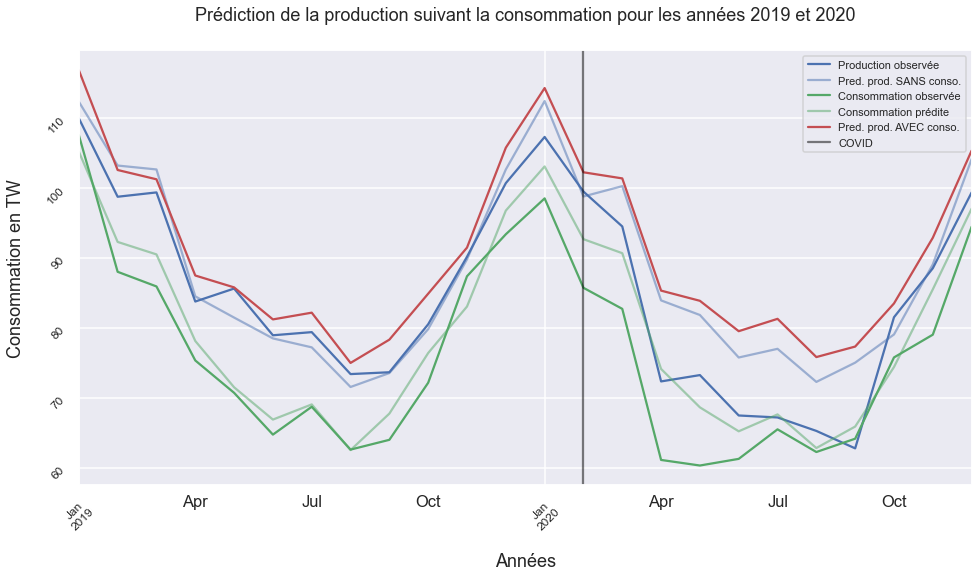

In [20]:
fig, ax = plt.subplots(figsize = (16,8))

test['prod'].plot(legend=True, color='b', alpha=1, label='Production observée')
test['pred_prod'].plot(legend=True, color='b', alpha=.5, label='Pred. prod. SANS conso.')

test['conso'].plot(legend=True, color='g', alpha=1, label='Consommation observée')
test['pred_conso'].plot(legend=True, color='g', alpha=.5, label='Consommation prédite')

ax = prediction.plot(legend=True, color='r', alpha=1, label='Pred. prod. AVEC conso.')

plt.xlabel('Années', labelpad=20)

plt.xticks(fontsize=12, rotation=45)

plt.ylabel('Consommation en TW', labelpad=20)
plt.yticks(fontsize=12, rotation=45)

plt.axvline(x=test.index[13], color='black', alpha=.5, label='COVID'); # Ajout de la ligne verticale


plt.title('Prédiction de la production suivant la consommation pour les années 2019 et 2020', pad=30)
plt.legend(fontsize=11, loc='best')
plt.savefig("Outputs/5.3_-_SARIMAX_prod_conso.png", dpi=150, bbox_inches='tight')
plt.show()

In [21]:
print('RMSE:', round(rmse(test['prod'], prediction), 4))
print('MAE:', round(meanabs(test['prod'], prediction), 4), '%')

RMSE: 7.2874
MAE: 5.9311 %


## III.3 - Interprétations SARIMAX
### 1. Graphique de prédiction
En intégrant la variable `consommation`, je m'attendais à des prédictions un peu plus proches des observations.

Encore une fois, pour l'année 2020, les prédictions sont relativement mauvaises étant donné la spécificité de la période COVID.

### 2. Metriques
Pour interpréter ces résultats, j'ai utilisé deux métriques:
* L'erreur quatratique moyenne (RMSE): moyenne des carrés des différences entre prédictions et observations.
* L'erreur absolue moyenne (MAE): moyenne arithmétique des valeurs absolues des écarts.

Les métriques sont un peu moins bonnes que celles de la prédiction sans la variable consommation.

# Conclusion

Malgré des résultats moins probants, ce modèle assure une marge de manoeuvre plus large et minimise un peu plus les risques de blackout.